In [79]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import scale, normalize
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder, CountEncoder, TargetEncoder
pd.options.mode.chained_assignment = None

In [2]:
def find_null(df_):
    '''
    Returns all indices with null values for every column in a DataFrame.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
    Returns
        nulls_ : Dictionary
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    nulls_ = {}
    for col in df_.columns:
        null_indices = total_df[col].loc[total_df[col].isnull()].index.values.tolist()
        nulls_[col] = null_indices
        
    return nulls_

In [3]:
def drop_null_cols(df_, col_to_check=[], threshold=0):
    '''
    Drop columns with null values above a threshold if specified.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_check : str, list or array-like, optional
            Column(s) to check for null values. Default is
            every column.
        threshold : int or float, optional
            Max number/percent of null values allowed in {col_to_check}.
            Default is 0.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_check, str):
        col_to_check = [col_to_check]
    elif not isinstance(col_to_check, list):
        col_to_check = list(col_to_check)
    if not col_to_check:
        col_to_check = df_.columns
    rows_size = df_.shape[0]
    # Drops columns that have null values above the specified threshold
    if isinstance(threshold, int):
        new_df = df_[col_to_check].dropna(axis=1, thresh=rows_size-threshold)
    elif threshold <= 1.0 and threshold >= 0.0:
        new_df = df_[col_to_check].dropna(axis=1, thresh=rows_size-int(rows_size*threshold))
    else:
        raise TypeError(f'{threshold} of wrong type or out of range')
    df_.drop(columns=np.setdiff1d(col_to_check, new_df.columns), inplace=True)
    return df_

In [4]:
def drop_null_rows(df_, col_to_check=[], threshold=0):
    '''
    Drop rows with null values above a threshold if specified.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_check : str, list or array-like, optional
            Column(s) to check for null values. Default is
            every column.
        threshold : int or float, optional
            Max number/percent of null values allowed in {col_to_check}
            of every row. Default is 0.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_check, str):
        col_to_check = [col_to_check]
    elif not isinstance(col_to_check, list):
        col_to_check = list(col_to_check)
    if not col_to_check:
        col_to_check = df_.columns
    cols_size = len(col_to_check)
    # Drop rows that have null values above the specified threshold
    if isinstance(threshold, int):
        df_.dropna(axis=0, thresh=cols_size-threshold,
                   subset=col_to_check, inplace=True)
    elif threshold <= 1.0 and threshold >= 0.0:
        df_.dropna(axis=0, thresh=cols_size-int(cols_size*threshold),
                   subset=col_to_check, inplace=True)
    else:
        raise TypeError(f'{threshold} of wrong type or out of range')
    return df_
    

In [5]:
def fill_null(col_, const_=None, col_replace_=None, lin_predict=None, oper_="", col_oper_=None):
    '''
    Fill null in {col_replace_} with {constant} or a transformation of {col_math_}.
    
    Parameters:
        col_ : list or array-like
            Column with null values to replace.
        const_ : int or float, optional
            Value to replace null in {col_} with. Default is 0.
        col_replace_ : list or array-like or Series, optional
            Values to replace null values in {col_}, must be of equal dimension.
            Default is 0.
        lin_predict_ : DataFrame, optional
            Replaces null values in {col_} with predictions from a
            linear regression model trained on the non-null values.
            Will drop rows with null values not in {col_} before training.
        oper_ : str, optional
            Replaces null values in {col_} with the operation specified
            for non-null in {col_oper_}.
            Mean, Median, Mode, Std, Min, Max, Range, 25, 75
        col_oper_ : Series, optional
            Column that will be operated upon by one of the above to fill
            the null values in {col_}. Default is {col_}.
    Returns:
        col_ : Series
    '''
    if not isinstance(col_, pd.Series):
        col_ = pd.Series(col_)
    # If no other parameters are passed, nulls will be set to 0.
    if (const_ is None and col_replace_ is None and lin_predict is None and
        oper_=="" and col_math_ is None):
        col_.fillna(0, inplace=True)
        return col_
    # Nulls will be set to const_.
    if const_:
        col_.fillna(const_, inplace=True)
        return col_
    # Nulls will be set to a list-like structure of equal length.
    if col_replace_ is not None:
        try:
            col_.loc[col_.isnull()] = list(col_replace_)
            return col_
        except ValueError:
            raise ValueError(f"Can't set length of {len(col_replace_)} to index of length {len(col_.loc[col_.isnull()])}")
    # Nulls will be predicted using linear regression.
    if lin_predict is not None:
        notnull_df_ = lin_predict.dropna()
        linreg = LinearRegression()
        train_x = notnull_df_.drop(columns=[col_.name])
        train_y = notnull_df_[col_.name]
        linreg.fit(train_x, train_y)
        test_y = linreg.predict(lin_predict.drop(columns=[col_.name]))
        col_.fillna(pd.Series(test_y), inplace=True)
        return col_
    # Nulls will be set to the mean of col_math_
    oper_ = oper_.lower()
    if col_oper_ is None:
        col_oper_ = col_
    elif not isinstance(col_oper_, pd.Series):
        col_oper_ = pd.Series(col_oper_)
    if oper_=="mean":
        col_.fillna(col_oper_.mean(), inplace=True)
    elif oper_=="median":
        col_.fillna(col_oper_.median(), inplace=True)
    elif oper_=="mode":
        col_.fillna(stats.mode(col_oper_)[0][0], inplace=True)
    elif oper_=="std":
        col_.fillna(col_oper_.std(), inplace=True)
    elif oper_=="min":
        col_.fillna(col_oper_.min(), inplace=True)
    elif oper_=="max":
        col_.fillna(col_oper_.max(), inplace=True)
    elif oper_=="range":
        col_.fillna(col_oper_.max()-col_math_.min(), inplace=True)
    elif oper_=="25":
        col_.fillna(col_oper_.describe()["25%"], inplace=True)
    elif oper_=="75":
        col_.fillna(col_oper_.describe()["75%"], inplace=True)
    return col_
    

In [6]:
def category_encode(df_, col_to_encode=[], encoder_type=None, target_col=[]):
    '''
    Transform categorical variables into integers through encoding.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_encode : str, list or array-like, optional
            Column(s) to encode. Default is every column.
        encoder_type : str, optional
            Method of encoding {col_to_encode}.
            OneHot, Ordinal, Count, or Target.
        target_col : str
            Target column, only used with TargetEncoder.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_encode, str):
        col_to_encode = [col_to_encode]
    elif not isinstance(col_to_encode, list):
        col_to_encode = list(col_to_encode)
    if not col_to_encode:
        col_to_encode = df_.columns
    encoder_type = encoder_type.lower()
    if encoder_type=="onehot":
        encoded = pd.get_dummies(df_[col_to_encode])
        df_.drop(columns=col_to_encode, inplace=True)
        df_ = df_.join(encoded)
        return df_
    if not encoder_type or encoder_type=="ordinal":
        encoder = OrdinalEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode])
    elif encoder_type=="count":
        encoder = CountEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode])
    elif encoder_type=="target":
        encoder = TargetEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode], df_[target_col])
    df_[col_to_encode] = encoded
    return df_
    

In [108]:
def corr_matrix(df_, exclude_label=None, method="pearson"):
    '''
    Returns a correlation matrix for the DataFrame.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        exclude_label : str, optional
            Exclude column from the correlation.
    Returns:
        df_corr : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    plt.rcParams['figure.facecolor'] = 'white'
    fig, ax = plt.subplots(figsize=(8, 6))
    if exclude_label:
        df_ = df_.drop(columns=[exclude_label])
    df_corr = df_.corr(method=method)
    mask = np.zeros_like(np.array(df_corr))
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(df_corr, mask=mask, annot=True)
    
    return df_corr

In [199]:
def box_plot(df_, exclude_label=None):
    '''
    Returns a boxplot for the DataFrame.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        exclude_label : str, optional
            Exclude column from the boxplot.
    Returns:
        outliers_per_column : Dict
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    plt.rcParams['figure.facecolor'] = 'white'
    fig, ax = plt.subplots(figsize=(9, 6))
    if exclude_label:
        df_ = df_.drop(columns=[exclude_label])
    df_stand_ = pd.DataFrame(scale(df_), columns=df_.columns)
    ax = sns.boxplot(data=df_stand_, orient="v", fliersize=2)
    outliers_per_column = {}
    for col in df_stand_.columns:
        col_data = {} 
        col_data["Max"] = df_stand_[col].max()
        col_data["75%"] = df_stand_[col].describe()["75%"]
        col_data["50%"] = df_stand_[col].median()
        col_data["25%"] = df_stand_[col].describe()["25%"]
        col_data["Min"] = df_stand_[col].min()
        col_data["Top_IQR"] = df_stand_[col].std()*1.5 + col_data["75%"]
        col_data["Bottom_IQR"] = col_data["25%"] - df_stand_[col].std()*1.5
        outliers_top = df_stand_[df_stand_[col] > col_data["Top_IQR"]][col]
        outliers_bottom = df_stand_[df_stand_[col] < col_data["Bottom_IQR"]][col]
        if (len(outliers_top) > 0):
            col_data["Top_Outliers"] = outliers_top.index.values
        else:
            col_data["Top_IQR"] = col_data["Max"]
        if (len(outliers_bottom > 0)):
            col_data["Bottom_Outliers"] = outliers_bottom.index.values
        else:
            col_data["Bottom_IQR"] = col_data["Min"]
        outliers_per_column[col] = col_data
        
    return outliers_per_column

In [217]:
total_df = pd.read_csv('../train.csv')
print(total_df[total_df["Embarked"].isna()].index.values)
total_df = drop_null_cols(total_df, threshold=0.2)
total_df = drop_null_rows(total_df, ["Embarked"])
total_df = category_encode(total_df, ["Sex", "Embarked"], "ordinal")
total_df["Age"] = fill_null(total_df["Age"], lin_predict=total_df[["Pclass", "Age", "Sex", "SibSp",
                                                                   "Parch", "Fare", "Embarked"]])
total_df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
total_df.reset_index(drop=True, inplace=True)
total_df[5:60]

[ 61 829]


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,1,27.854196,0,0,8.4583,3
6,0,1,1,54.000000,0,0,51.8625,1
7,0,3,1,2.000000,3,1,21.0750,1
8,1,3,2,27.000000,0,2,11.1333,1
9,1,2,2,14.000000,1,0,30.0708,2
10,1,3,2,4.000000,1,1,16.7000,1
11,1,1,2,58.000000,0,0,26.5500,1
12,0,3,1,20.000000,0,0,8.0500,1
13,0,3,1,39.000000,1,5,31.2750,1
14,0,3,2,14.000000,0,0,7.8542,1


{'Age': {'Max': 3.7777756626013725,
  '75%': 0.5134536476018327,
  '50%': -0.09578232426695861,
  '25%': -0.6024429912634974,
  'Min': -2.5647766726493737,
  'Top_IQR': 2.01429800455021,
  'Bottom_IQR': -2.103287348211875,
  'Top_Outliers': array([ 11,  33,  54,  93,  95, 115, 169, 194, 231, 251, 267, 274, 279,
         325, 365, 437, 455, 482, 486, 492, 544, 554, 569, 586, 624, 625,
         629, 658, 671, 683, 693, 744, 771, 849], dtype=int64),
  'Bottom_Outliers': array([ 77, 157, 163, 171, 182, 304, 380, 385, 468, 643, 754, 787, 802,
         826, 829], dtype=int64)},
 'SibSp': {'Max': 6.77719548008876,
  '75%': 0.4313502389523841,
  '50%': -0.4751990812099552,
  '25%': -0.4751990812099552,
  'Min': -0.4751990812099552,
  'Top_IQR': 1.932194595900774,
  'Bottom_IQR': -0.4751990812099552,
  'Top_Outliers': array([  7,  16,  24,  27,  50,  59,  62,  67,  70,  84,  87, 118, 158,
         163, 170, 175, 179, 181, 200, 228, 232, 260, 265, 277, 323, 340,
         373, 385, 408, 479, 484,

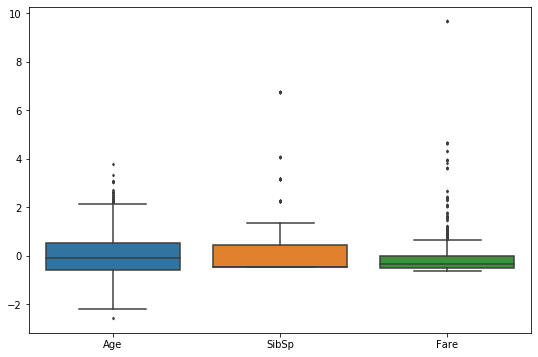

In [214]:
#corr_ = corr_matrix(total_df, exclude_label="Survived")
outliers_ = box_plot(total_df[["Age", "SibSp", "Fare"]])
outliers_